In this kernel, we will learn about what is windowing and how exactly it is helpful.

Credits to - https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained

### Windowing: 
Windowing, also known as **grey-level mapping**, **contrast stretching**, **histogram modification** or **contrast enhancement** is the process in which the CT image greyscale component of an image is manipulated via the CT numbers; doing this will change the appearance of the picture to highlight particular structures. The brightness of the image is adjusted via the window level. The contrast is adjusted via the window width.

Tissue density is measured in [Hounsfield units (HU)](https://en.wikipedia.org/wiki/Hounsfield_scale)

* This is defined as **Air = −1000 HU**; **Water = 0 HU.**

Density of tissues in CT-Scans: $$Air < Fat < Fluid < Soft tissue < Bone < Metal$$
The easier way to remember this is (Fat floats on water, so is less dense than fluid; Soft tissue is mostly intracellular fluid with some connective tissue)

* Air = −1000 HU
* Lung ≈ −500 HU (partially air, partially soft tissue)
* Fat ≈ −50 HU (slightly less dense than simple fluid)
* Water = 0 HU
* Soft tissue (& blood) ≈ +50 HU (slightly more dense than simple fluid)
* Bone ≈ +1000 HU (much more dense)

![](https://www.radiologycafe.com/images/basics/window-basic.png)
To ascertain a window, a ‘level’ and a ‘width’ is defined. For example, a window with a level of 0 HU and a width of 400 HU will have a range of −200 HU to +200 HU. Any tissue with a density of −200 HU or less will be black, and any tissue with a density of +200 HU or more will be white. And values between -200 HU to +200 HU will be spread between the whole grayscale range. A **window** can be set to look at certain tissues of interest. **A small range of tissue density is represented by a full greyscale spectrum from black to white, thus making subtle density differences within the specified range easier to see.**






### Typical window width and level values: 
Although this varies somewhat from institution to institution and vendor to vendor, window width and centers are generally fairly similar. **The values below are written as width and level (W:x L:y) in Hounsfield units (HU).**

* head and neck
* brain W:80 L:40
* subdural W:130-300 L:50-100
* stroke W:8 L:32 or W:40 L:40 3
* temporal bones W:2800 L:600
* soft tissues: W:350–400 L:20–60 4
* chest
* lungs W:1500 L:-600
* mediastinum W:350 L:50
* abdomen
* soft tissues W:400 L:50
* liver W:150 L:30
* spine
* soft tissues W:250 L:50
* bone W:1800 L:400



### Window width
The window width (WW) as the name suggests is the measure of the range of CT numbers that an image contains. A wider window width (2000 HU), therefore, will display a wider range of CT numbers. Consequently, the transition of dark to light structures will occur over a larger transition area to that of a narrow window width (<1000 HU). Accordingly, it is important to note, that a significantly wide window displaying all the CT numbers will result in different attenuations between soft tissues to become obscured.

**Wide window:** When you are looking at an area with predominantly different tissue density, a wide window is used. A good example is lungs or cortical tissue, where air and vessels will sit side by side.

**Narrow window:** When you are looking at tissues with almost similar density, you should use narrow window. As a result subtle changes in tissued density (small window) is magnified over the whole grayscale range. 

### Window level/center
The window level (WL), often also referred to as window center, is the midpoint of the range of the CT numbers displayed. **When the window level is decreased the CT image will be brighter and vice versa.** 

### Upper and lower grey level calculation 
When presented with a Window width (WW) and Widnow Level (WL) one can calculate the upper and lower grey levels i.e. values over x will be white and values below y will be black. 

* the upper grey level (x) is calculated via WL + (WW ÷ 2)
* the lower grey level (y) is calculated via WL - (WW ÷ 2)

For example, a brain is W:80 L:40.  Therefore, all values above +80 will be set to maximum grayscale level (white) and all values below 0 will be set to lowest grayscale level in the display (black). And values between +0 to +80 will be spread between the whole grayscale range.  

Examples of commonly used windows are soft tissue, lung, and bone are given below: 

## LIbraries

In [1]:
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from glob import glob
import warnings

## Data

In [3]:
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

TRAIN_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

# Show first few entries
train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


## Images

In [4]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = pydicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

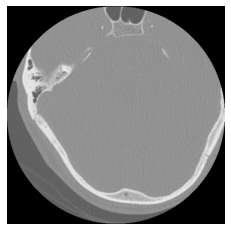

In [5]:
sample = '1.2.826.0.1.3680043.10001/1.dcm'
image, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')

plt.figure()
plt.axis('off')
plt.imshow(image)

## Utility

In [6]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale: 
        img = (img - img_min) / (img_max - img_min)*255.0 
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [7]:
def view_images(files, title = '', aug = None, windowing = True):
    width = 2
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,15))
    
    for im in range(0, height * width):
        data = pydicom.dcmread(files[im])
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        if windowing:
            output = window_image(image, window_center, window_width, intercept, slope, rescale = False)
        else:
            output = image
        i = im // width
        j = im % width
        axs[i,j].imshow(output, cmap=plt.cm.gray) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

In [8]:
list_to_view = [f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10041/{dcm_file}'
                for dcm_file in os.listdir(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10041')]

print(f'there are {len(list_to_view)} files in this directory')

there are 220 files in this directory


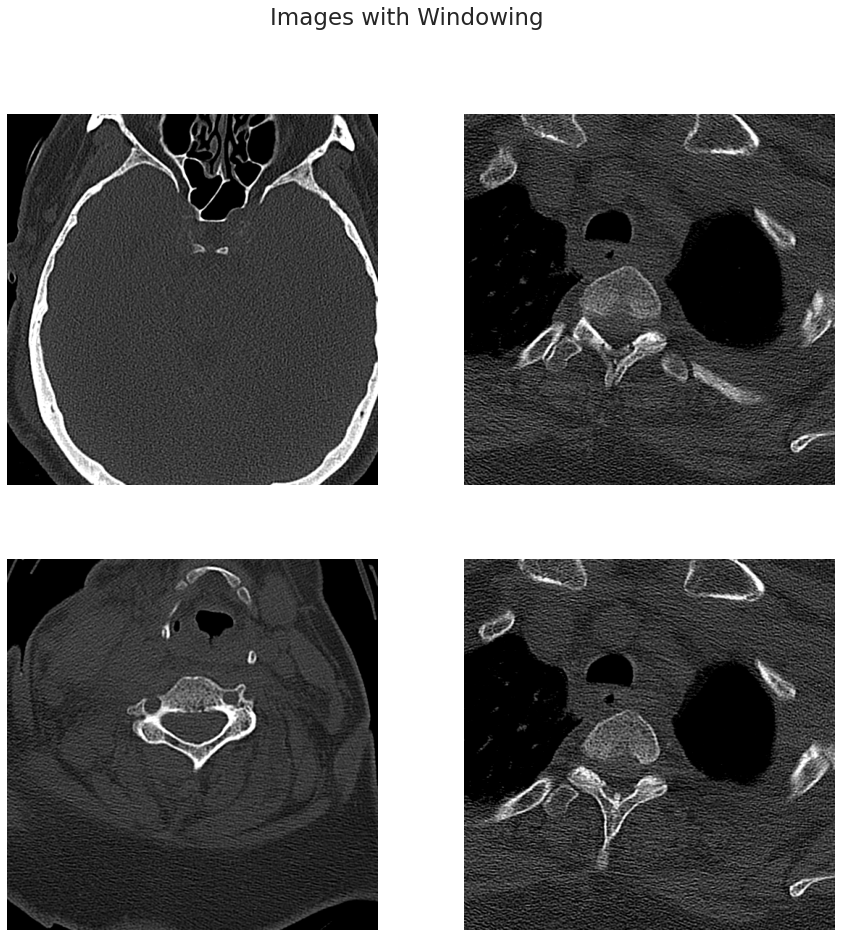

In [9]:
view_images(list_to_view[:10], 'Images with Windowing')

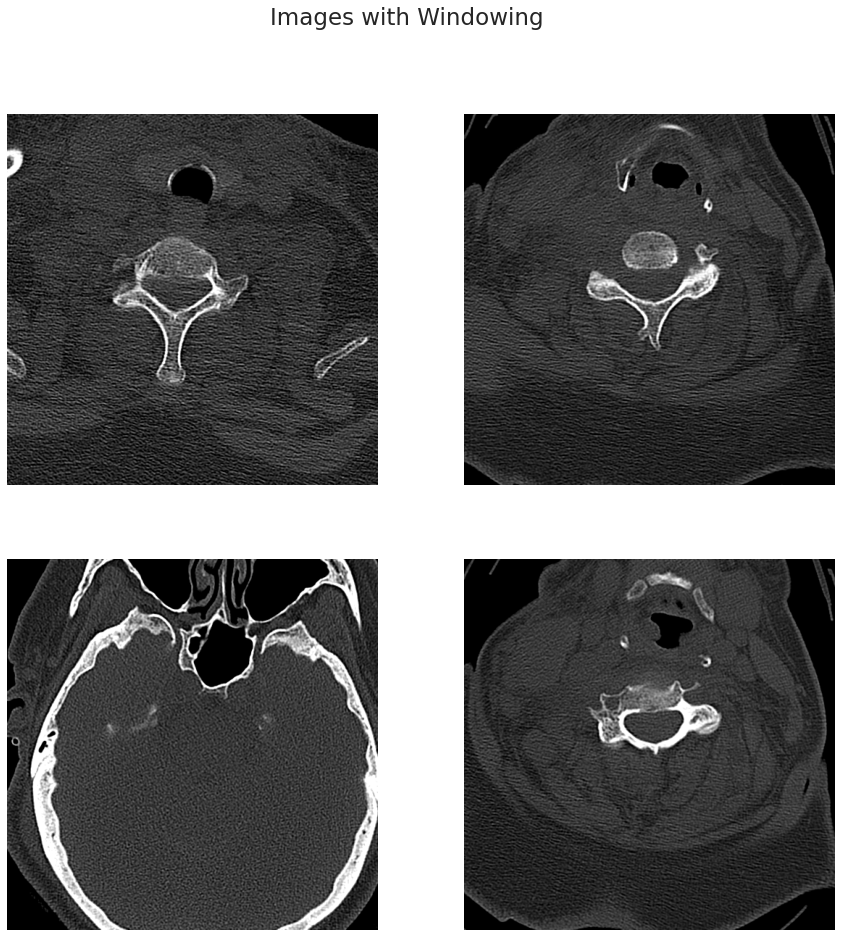

In [10]:
view_images(list_to_view[10:20], 'Images with Windowing')

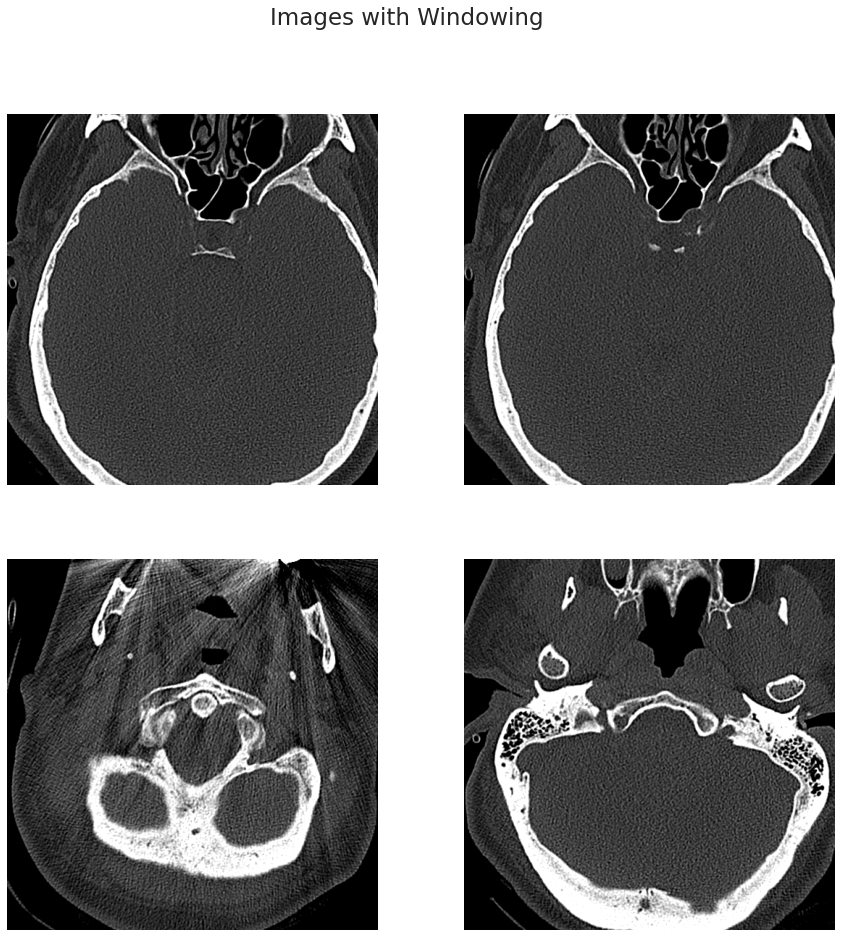

In [11]:
view_images(list_to_view[20:30], 'Images with Windowing')